In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision

In [34]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Function to split and load data
def load_cifar_100(batch_size=32, validation_split=0.1, test_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

    # Split dataset into training+validation and test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(dataset)), test_size=test_split, random_state=42
    )

    # Split train_val into training and validation
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=validation_split, random_state=42
    )

    # Define samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create dataloaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [36]:
# Function to load and split data with augmentations
def load_cifar_100_v1(batch_size=32, validation_split=0.1, test_split=0.2):
    # Data augmentations for training
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Random scaling
        transforms.RandomRotation(20),  # Rotation within 20 degrees
        transforms.RandomHorizontalFlip(),  # Horizontal flipping
        transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.25, hue=0.15),  # Color adjustments
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])

    # No augmentation for validation and test
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load dataset
    dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

    # Split into training, validation, and test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(dataset)), test_size=test_split, random_state=42
    )

    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=validation_split, random_state=42
    )

    # Define samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create dataloaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [37]:
# Plot metrics function
def plot_summary(n_epochs, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy):
    N = np.arange(n_epochs) + 1

    fig = plt.figure(figsize=(12, 5))

    # Loss Curve
    fig.add_subplot(1, 2, 1)
    plt.plot(N, train_loss, 'r-s', linewidth=3, label='Train Loss')
    plt.plot(N, val_loss, 'b-p', linewidth=3, label='Validation Loss')
    plt.plot(N, test_loss, 'k--', linewidth=3, label='Test Loss')
    plt.title('Loss Curve', fontsize=16)
    plt.xlabel('No. of Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)

    # Accuracy Curve
    fig.add_subplot(1, 2, 2)
    plt.plot(N, train_accuracy, 'g-D', linewidth=3, label='Train Accuracy')
    plt.plot(N, val_accuracy, 'c-P', linewidth=3, label='Validation Accuracy')
    plt.plot(N, test_accuracy, 'm--', linewidth=3, label='Test Accuracy')
    plt.title('Accuracy Curve', fontsize=16)
    plt.xlabel('No. of Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

In [38]:
# Train and evaluate model
def TrainTest_model(model, train_loader, val_loader, test_loader, epochs=10, lr=1e-3, save_path="model.pth"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics
    train_loss, val_loss, test_loss = [], [], []
    train_accuracy, val_accuracy, test_accuracy = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate train metrics
        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(100 * correct_train / total_train)

        # Validation phase
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss.append(running_val_loss / len(val_loader))
        val_accuracy.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}%, "
              f"Val Acc: {val_accuracy[-1]:.2f}%")

    # Save model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    # Test phase
    model.eval()
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss_value = running_test_loss / len(test_loader)
    test_accuracy_value = 100 * correct_test / total_test

    # Append test results for consistent plotting
    test_loss = [test_loss_value] * epochs
    test_accuracy = [test_accuracy_value] * epochs

    print(f"Test Loss: {test_loss_value:.4f}, Test Accuracy: {test_accuracy_value:.2f}%")

    # Plot metrics
    plot_summary(epochs, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy)

In [39]:
# DenseNet = models.densenet121(weights=True)
# ResNet = models.resnet18(weights=True)
# VGG16 = models.vgg16(weights=True)
# AlexNet = models.alexnet(weights=True)

Files already downloaded and verified
Files already downloaded and verified
Training AlexNet
Epoch 1/15 -> Train Loss: 3.7860, Val Loss: 3.1969, Train Acc: 11.31%, Val Acc: 20.25%
Epoch 2/15 -> Train Loss: 2.6331, Val Loss: 2.4201, Train Acc: 30.96%, Val Acc: 36.85%
Epoch 3/15 -> Train Loss: 2.0296, Val Loss: 1.9168, Train Acc: 44.43%, Val Acc: 47.27%
Epoch 4/15 -> Train Loss: 1.6517, Val Loss: 1.6698, Train Acc: 53.19%, Val Acc: 52.40%
Epoch 5/15 -> Train Loss: 1.3703, Val Loss: 1.5570, Train Acc: 60.18%, Val Acc: 55.75%
Epoch 6/15 -> Train Loss: 1.1275, Val Loss: 1.5216, Train Acc: 66.89%, Val Acc: 58.85%
Epoch 7/15 -> Train Loss: 0.8948, Val Loss: 1.4612, Train Acc: 72.69%, Val Acc: 60.08%
Epoch 8/15 -> Train Loss: 0.6838, Val Loss: 1.4899, Train Acc: 78.71%, Val Acc: 60.65%
Epoch 9/15 -> Train Loss: 0.4966, Val Loss: 1.6868, Train Acc: 84.28%, Val Acc: 58.75%
Epoch 10/15 -> Train Loss: 0.3589, Val Loss: 1.6936, Train Acc: 88.55%, Val Acc: 59.25%
Epoch 11/15 -> Train Loss: 0.2695, V

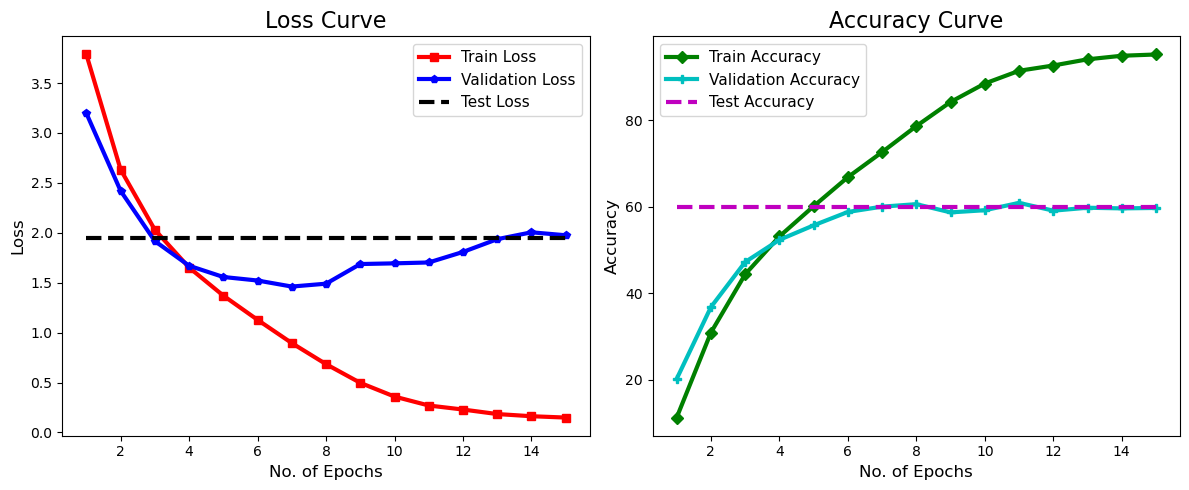

Training DenseNet


c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 -> Train Loss: 2.3712, Val Loss: 1.8098, Train Acc: 37.76%, Val Acc: 49.73%
Epoch 2/15 -> Train Loss: 1.4755, Val Loss: 1.4003, Train Acc: 57.57%, Val Acc: 59.77%
Epoch 3/15 -> Train Loss: 1.1520, Val Loss: 1.3150, Train Acc: 66.14%, Val Acc: 62.65%
Epoch 4/15 -> Train Loss: 0.9596, Val Loss: 1.2538, Train Acc: 71.20%, Val Acc: 64.72%
Epoch 5/15 -> Train Loss: 0.7725, Val Loss: 1.1979, Train Acc: 76.33%, Val Acc: 66.65%
Epoch 6/15 -> Train Loss: 0.6384, Val Loss: 1.1648, Train Acc: 80.00%, Val Acc: 67.67%
Epoch 7/15 -> Train Loss: 0.5124, Val Loss: 1.1885, Train Acc: 83.67%, Val Acc: 68.80%
Epoch 8/15 -> Train Loss: 0.4330, Val Loss: 1.2879, Train Acc: 86.09%, Val Acc: 67.53%
Epoch 9/15 -> Train Loss: 0.3487, Val Loss: 1.2670, Train Acc: 88.68%, Val Acc: 69.12%
Epoch 10/15 -> Train Loss: 0.3021, Val Loss: 1.3795, Train Acc: 90.14%, Val Acc: 68.35%
Epoch 11/15 -> Train Loss: 0.2541, Val Loss: 1.2898, Train Acc: 91.93%, Val Acc: 70.30%
Epoch 12/15 -> Train Loss: 0.2394, Val Lo

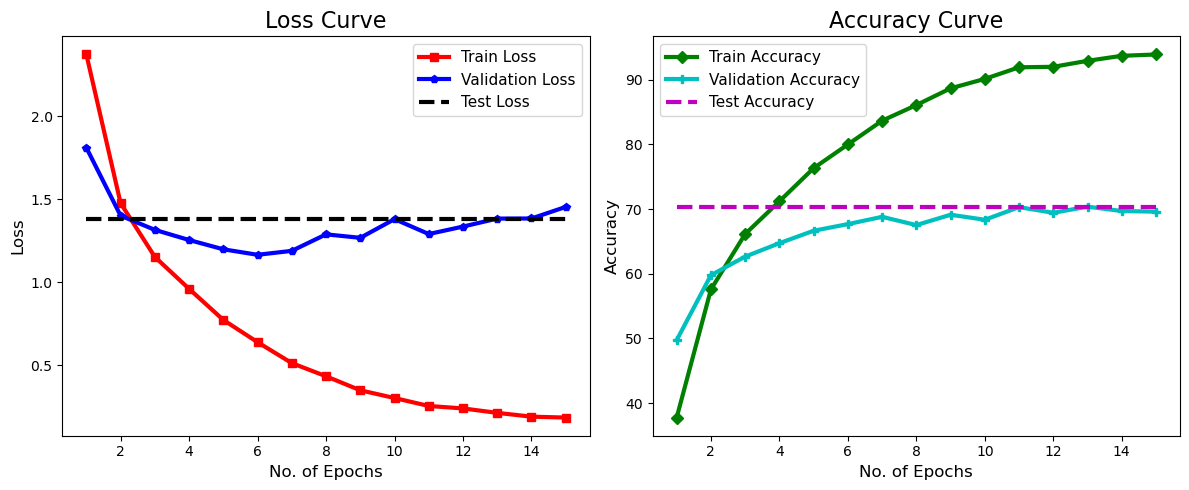

Training ResNet


c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 -> Train Loss: 4.3857, Val Loss: 4.1813, Train Acc: 3.10%, Val Acc: 4.95%
Epoch 2/15 -> Train Loss: 4.1394, Val Loss: 3.9698, Train Acc: 6.14%, Val Acc: 8.15%
Epoch 3/15 -> Train Loss: 3.9237, Val Loss: 3.7558, Train Acc: 9.31%, Val Acc: 12.18%
Epoch 4/15 -> Train Loss: 3.7423, Val Loss: 3.5828, Train Acc: 11.97%, Val Acc: 14.62%
Epoch 5/15 -> Train Loss: 3.6027, Val Loss: 3.5653, Train Acc: 14.27%, Val Acc: 15.22%
Epoch 6/15 -> Train Loss: 3.4955, Val Loss: 3.4355, Train Acc: 16.28%, Val Acc: 17.55%
Epoch 7/15 -> Train Loss: 3.4078, Val Loss: 3.3205, Train Acc: 18.03%, Val Acc: 20.62%
Epoch 8/15 -> Train Loss: 3.3316, Val Loss: 3.2737, Train Acc: 19.55%, Val Acc: 20.80%
Epoch 9/15 -> Train Loss: 3.2589, Val Loss: 3.2469, Train Acc: 20.37%, Val Acc: 22.73%
Epoch 10/15 -> Train Loss: 3.2067, Val Loss: 3.1779, Train Acc: 21.56%, Val Acc: 23.50%
Epoch 11/15 -> Train Loss: 3.1463, Val Loss: 3.1234, Train Acc: 23.10%, Val Acc: 25.23%
Epoch 12/15 -> Train Loss: 3.1113, Val Loss: 3

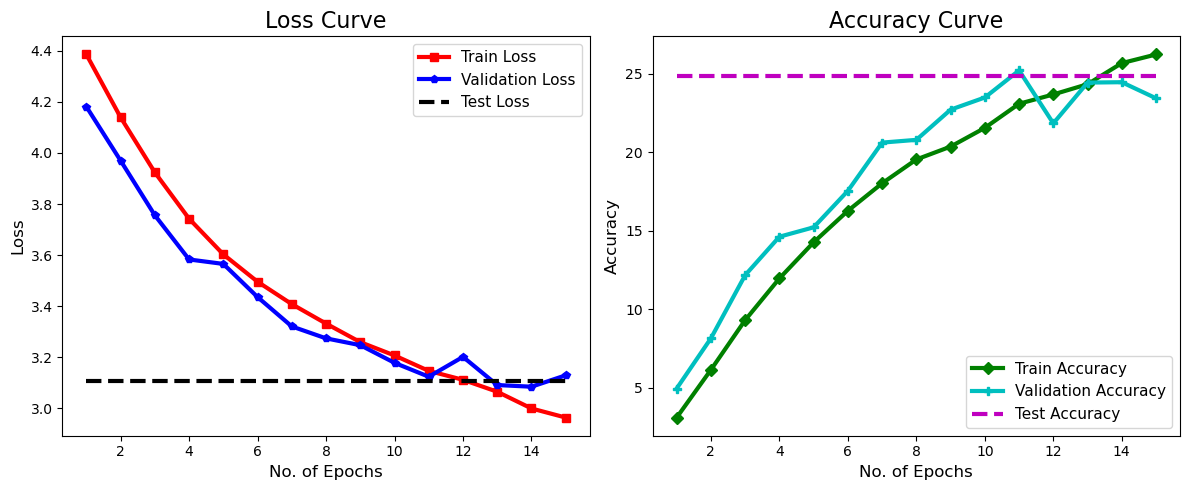

In [40]:
# Main script
if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_cifar_100()

    print("Training AlexNet")
    model1 = models.resnet50(weights=True)
    model1.fc = nn.Linear(model1.fc.in_features, 100)  # Adjust for CIFAR-100 classes
    TrainTest_model(model1, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomAlexNet.pth")

    print("Training DenseNet")
    model2 = models.densenet121(weights=True)
    model2.classifier = nn.Linear(model2.classifier.in_features, 100)
    TrainTest_model(model2, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomDenseNet.pth")

    print("Training ResNet")
    model3 = models.alexnet(weights=True)
    model3.classifier[6] = nn.Linear(model3.classifier[6].in_features, 100)
    TrainTest_model(model3, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomResNet.pth")



Files already downloaded and verified
Files already downloaded and verified
Training AlexNet
Epoch 1/15 -> Train Loss: 4.2783, Val Loss: 4.0135, Train Acc: 4.70%, Val Acc: 8.65%
Epoch 2/15 -> Train Loss: 3.7238, Val Loss: 3.4534, Train Acc: 12.27%, Val Acc: 16.32%
Epoch 3/15 -> Train Loss: 3.2308, Val Loss: 3.0770, Train Acc: 20.49%, Val Acc: 23.05%
Epoch 4/15 -> Train Loss: 2.8787, Val Loss: 2.7278, Train Acc: 27.39%, Val Acc: 30.27%
Epoch 5/15 -> Train Loss: 2.6062, Val Loss: 2.6373, Train Acc: 32.88%, Val Acc: 32.48%
Epoch 6/15 -> Train Loss: 2.3951, Val Loss: 2.3633, Train Acc: 37.42%, Val Acc: 38.30%
Epoch 7/15 -> Train Loss: 2.2150, Val Loss: 2.1865, Train Acc: 41.27%, Val Acc: 41.90%
Epoch 8/15 -> Train Loss: 2.0667, Val Loss: 2.1168, Train Acc: 44.66%, Val Acc: 44.83%
Epoch 9/15 -> Train Loss: 1.9356, Val Loss: 2.0753, Train Acc: 47.73%, Val Acc: 44.58%
Epoch 10/15 -> Train Loss: 1.8339, Val Loss: 1.8897, Train Acc: 50.12%, Val Acc: 48.38%
Epoch 11/15 -> Train Loss: 1.7352, Val

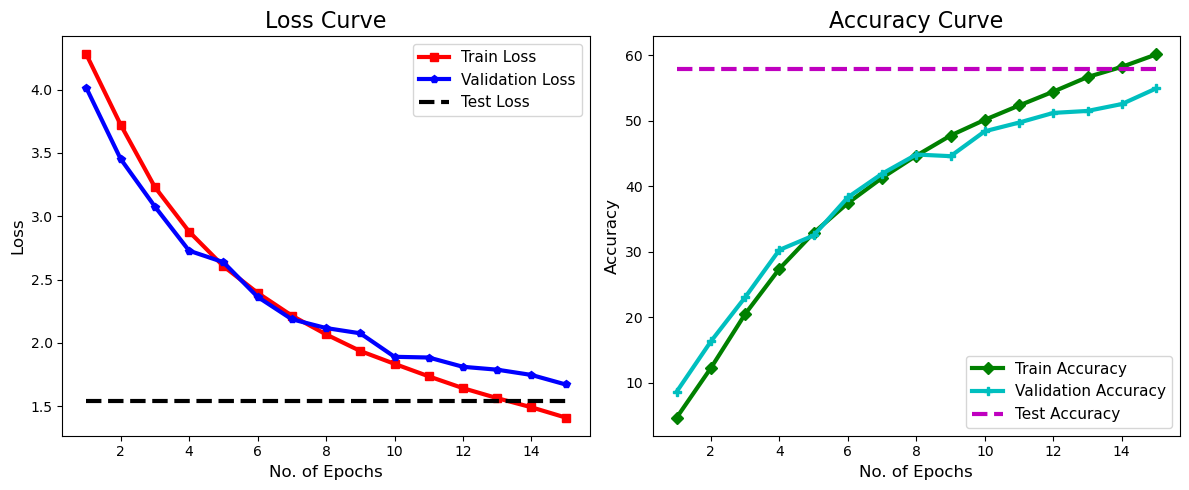

Training DenseNet
Epoch 1/15 -> Train Loss: 3.2420, Val Loss: 2.4264, Train Acc: 20.86%, Val Acc: 35.92%
Epoch 2/15 -> Train Loss: 2.0977, Val Loss: 1.9048, Train Acc: 43.10%, Val Acc: 47.80%
Epoch 3/15 -> Train Loss: 1.7304, Val Loss: 1.7011, Train Acc: 51.95%, Val Acc: 53.08%
Epoch 4/15 -> Train Loss: 1.5180, Val Loss: 1.6975, Train Acc: 57.24%, Val Acc: 54.02%
Epoch 5/15 -> Train Loss: 1.3531, Val Loss: 1.4312, Train Acc: 61.16%, Val Acc: 59.20%
Epoch 6/15 -> Train Loss: 1.2300, Val Loss: 1.3573, Train Acc: 64.66%, Val Acc: 61.83%
Epoch 7/15 -> Train Loss: 1.1380, Val Loss: 1.3293, Train Acc: 66.64%, Val Acc: 62.48%
Epoch 8/15 -> Train Loss: 1.0523, Val Loss: 1.2816, Train Acc: 68.99%, Val Acc: 64.30%
Epoch 9/15 -> Train Loss: 0.9714, Val Loss: 1.2546, Train Acc: 71.24%, Val Acc: 64.72%
Epoch 10/15 -> Train Loss: 0.9044, Val Loss: 1.2297, Train Acc: 72.90%, Val Acc: 65.25%
Epoch 11/15 -> Train Loss: 0.8419, Val Loss: 1.2091, Train Acc: 74.54%, Val Acc: 66.45%
Epoch 12/15 -> Train Lo

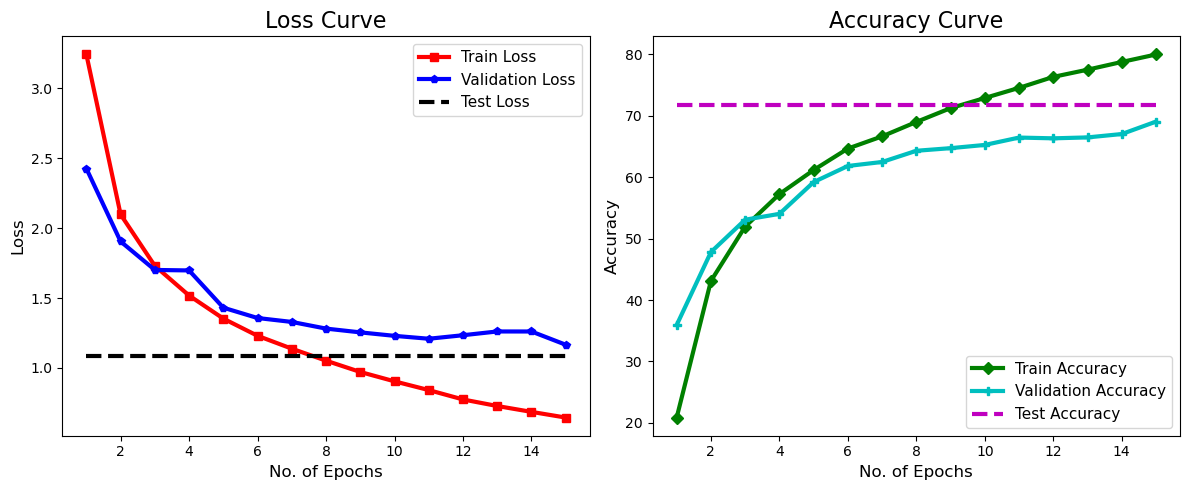

Training ResNet
Epoch 1/15 -> Train Loss: 4.6091, Val Loss: 4.6083, Train Acc: 0.88%, Val Acc: 0.80%
Epoch 2/15 -> Train Loss: 4.6069, Val Loss: 4.6069, Train Acc: 0.92%, Val Acc: 0.93%
Epoch 3/15 -> Train Loss: 4.6269, Val Loss: 4.6065, Train Acc: 1.04%, Val Acc: 1.02%
Epoch 4/15 -> Train Loss: 4.6064, Val Loss: 4.6070, Train Acc: 0.95%, Val Acc: 0.85%
Epoch 5/15 -> Train Loss: 4.6063, Val Loss: 4.6069, Train Acc: 0.99%, Val Acc: 0.85%
Epoch 6/15 -> Train Loss: 4.6063, Val Loss: 4.6073, Train Acc: 0.95%, Val Acc: 0.85%
Epoch 7/15 -> Train Loss: 4.6062, Val Loss: 4.6076, Train Acc: 0.99%, Val Acc: 0.65%
Epoch 8/15 -> Train Loss: 4.6063, Val Loss: 4.6072, Train Acc: 0.92%, Val Acc: 0.85%
Epoch 9/15 -> Train Loss: 4.6063, Val Loss: 4.6076, Train Acc: 1.05%, Val Acc: 1.02%
Epoch 10/15 -> Train Loss: 4.6062, Val Loss: 4.6084, Train Acc: 0.93%, Val Acc: 1.02%
Epoch 11/15 -> Train Loss: 4.6063, Val Loss: 4.6074, Train Acc: 0.94%, Val Acc: 1.02%
Epoch 12/15 -> Train Loss: 4.6063, Val Loss: 4.

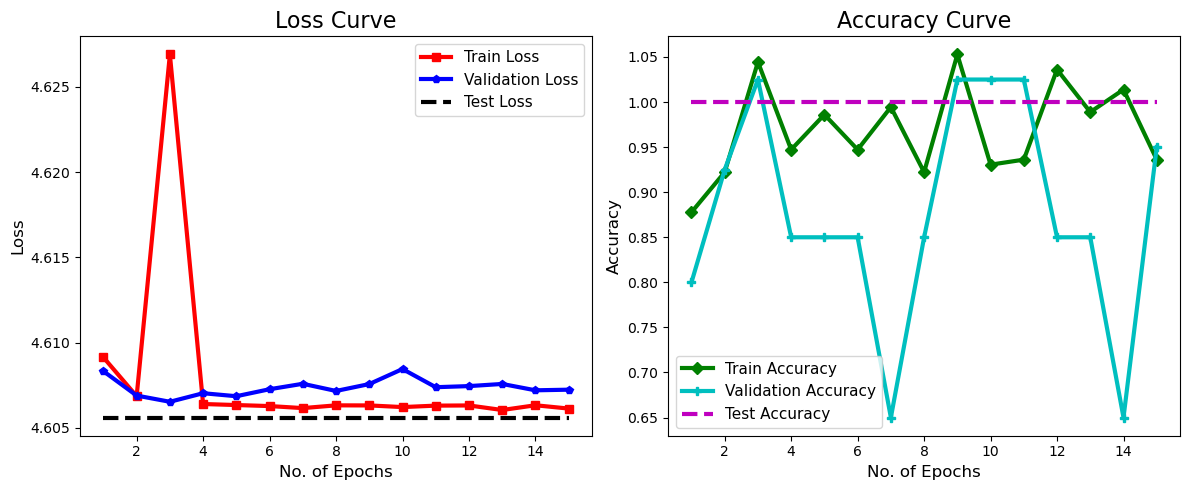

In [41]:
# Main script
if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_cifar_100_v1()

    print("Training AlexNet")
    model1 = models.resnet50(weights=True)
    model1.fc = nn.Linear(model1.fc.in_features, 100)  # Adjust for CIFAR-100 classes
    TrainTest_model(model1, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomAlexNet_v1.pth")

    print("Training DenseNet")
    model2 = models.densenet121(weights=True)
    model2.classifier = nn.Linear(model2.classifier.in_features, 100)
    TrainTest_model(model2, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomDenseNet_v1.pth")

    print("Training ResNet")
    model3 = models.alexnet(weights=True)
    model3.classifier[6] = nn.Linear(model3.classifier[6].in_features, 100)
    TrainTest_model(model3, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomResNet_v1.pth")

In [42]:
# Load test data
def load_test_data(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

def load_model(model_name, model_path):
    if model_name == "DenseNet":
        model = models.densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, 100)
    elif model_name == "ResNet":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 100)
    elif model_name == "AlexNet":
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 100)
    else:
        raise ValueError("Unsupported model name!")

    # Load saved weights, check for model compatibility
    state_dict = torch.load(model_path, map_location=device)
    model_dict = model.state_dict()
    
    # Filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
    model_dict.update(state_dict)  # update the model state dictionary with the loaded weights
    model.load_state_dict(model_dict)
    
    model.to(device)
    model.eval()
    return model


# Perform ensemble predictions
def ensemble_predictions(models, test_loader):
    all_outputs = []

    # Run each model on the test data
    for model in models:
        outputs = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                output = torch.softmax(model(inputs), dim=1)  # Get probabilities
                outputs.append(output.cpu().numpy())
        all_outputs.append(np.vstack(outputs))  # Combine batch outputs

    # Average predictions across all models (soft voting)
    avg_outputs = np.mean(np.array(all_outputs), axis=0)
    return avg_outputs

# Evaluate ensemble performance
def evaluate_ensemble(test_loader, avg_outputs):
    correct, total = 0, 0
    all_labels = []

    # Collect all test labels
    for _, labels in test_loader:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)

    # Get final predictions from the ensemble
    predicted_labels = np.argmax(avg_outputs, axis=1)

    # Calculate accuracy
    correct = np.sum(predicted_labels == all_labels)
    total = len(all_labels)
    accuracy = 100 * correct / total
    print(f"Ensemble Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [43]:
# Main script
if __name__ == "__main__":
    # Load test data
    test_loader = load_test_data()

    # Paths to the saved models
    model_paths = {
        "ResNet": "CustomResNet.pth",
        "DenseNet": "CustomDenseNet.pth",
        "AlexNet": "CustomAlexNet.pth"
    }

    # Load models
    models_list = []
    for model_name, model_path in model_paths.items():
        print(f"Loading model: {model_name}")
        model = load_model(model_name, model_path)
        models_list.append(model)

    # Perform ensemble predictions
    print("Generating ensemble predictions raw...")
    avg_outputs = ensemble_predictions(models_list, test_loader)

    # Evaluate ensemble performance
    print("Evaluating ensemble raw...")
    evaluate_ensemble(test_loader, avg_outputs)

Files already downloaded and verified
Loading model: ResNet


c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\dyagb\AppData\Local\Temp\ipykernel_48008\560586210.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value

Loading model: DenseNet
Loading model: AlexNet
Generating ensemble predictions raw...
Evaluating ensemble raw...
Ensemble Test Accuracy: 60.14%


In [44]:
# Main script
if __name__ == "__main__":
    # Load test data
    test_loader = load_test_data()

    # Paths to the saved models
    model_paths = {
        "ResNet": "CustomResNet_v1.pth",
        "DenseNet": "CustomDenseNet_v1.pth",
        "AlexNet": "CustomAlexNet_v1.pth"
    }

    # Load models
    models_list = []
    for model_name, model_path in model_paths.items():
        print(f"Loading model: {model_name}")
        model = load_model(model_name, model_path)
        models_list.append(model)

    # Perform ensemble predictions
    print("Generating ensemble predictions augmented...")
    avg_outputs = ensemble_predictions(models_list, test_loader)

    # Evaluate ensemble performance
    print("Evaluating ensemble augmented...")
    evaluate_ensemble(test_loader, avg_outputs)

Files already downloaded and verified
Loading model: ResNet


C:\Users\dyagb\AppData\Local\Temp\ipykernel_48008\560586210.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Loading model: DenseNet
Loading model: AlexNet
Generating ensemble predictions augmented...
Evaluating ensemble augmented...
Ensemble Test Accuracy: 66.26%


Files already downloaded and verified
Files already downloaded and verified
Training AlexNet


c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 -> Train Loss: 4.2152, Val Loss: 3.7840, Train Acc: 4.93%, Val Acc: 9.90%
Epoch 2/30 -> Train Loss: 3.5610, Val Loss: 3.3313, Train Acc: 14.42%, Val Acc: 19.30%
Epoch 3/30 -> Train Loss: 3.0466, Val Loss: 3.0297, Train Acc: 23.77%, Val Acc: 24.15%
Epoch 4/30 -> Train Loss: 2.6745, Val Loss: 2.6675, Train Acc: 30.89%, Val Acc: 31.35%
Epoch 5/30 -> Train Loss: 2.3973, Val Loss: 2.2543, Train Acc: 37.05%, Val Acc: 40.48%
Epoch 6/30 -> Train Loss: 2.1688, Val Loss: 2.1611, Train Acc: 42.25%, Val Acc: 41.65%
Epoch 7/30 -> Train Loss: 2.0035, Val Loss: 2.0435, Train Acc: 45.84%, Val Acc: 45.33%
Epoch 8/30 -> Train Loss: 1.8491, Val Loss: 1.9038, Train Acc: 49.36%, Val Acc: 48.23%
Epoch 9/30 -> Train Loss: 1.7260, Val Loss: 1.9335, Train Acc: 52.26%, Val Acc: 48.45%
Epoch 10/30 -> Train Loss: 1.6129, Val Loss: 1.6970, Train Acc: 54.98%, Val Acc: 52.90%
Epoch 11/30 -> Train Loss: 1.5133, Val Loss: 1.6895, Train Acc: 57.41%, Val Acc: 53.65%
Epoch 12/30 -> Train Loss: 1.4140, Val Loss

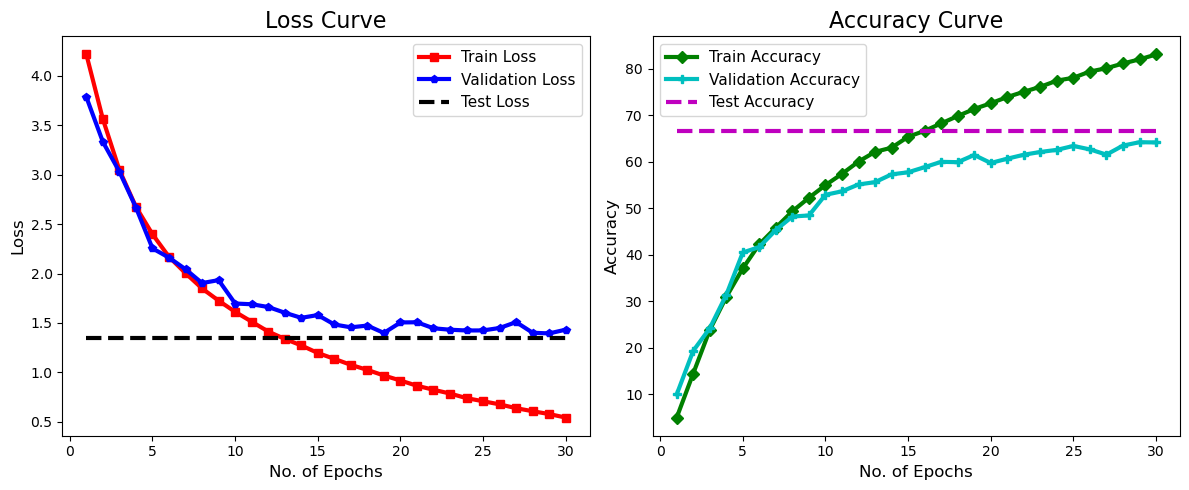

Training DenseNet


c:\Users\dyagb\anaconda3\envs\Project_D2L\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 -> Train Loss: 2.8976, Val Loss: 2.2056, Train Acc: 27.58%, Val Acc: 40.77%
Epoch 2/30 -> Train Loss: 1.9379, Val Loss: 1.7601, Train Acc: 47.08%, Val Acc: 50.45%
Epoch 3/30 -> Train Loss: 1.6237, Val Loss: 1.6437, Train Acc: 54.28%, Val Acc: 54.33%
Epoch 4/30 -> Train Loss: 1.4233, Val Loss: 1.4743, Train Acc: 59.67%, Val Acc: 58.00%
Epoch 5/30 -> Train Loss: 1.2828, Val Loss: 1.3995, Train Acc: 63.03%, Val Acc: 60.52%
Epoch 6/30 -> Train Loss: 1.1819, Val Loss: 1.3194, Train Acc: 65.64%, Val Acc: 62.90%
Epoch 7/30 -> Train Loss: 1.0845, Val Loss: 1.2948, Train Acc: 68.07%, Val Acc: 64.20%
Epoch 8/30 -> Train Loss: 0.9952, Val Loss: 1.2525, Train Acc: 70.32%, Val Acc: 65.62%
Epoch 9/30 -> Train Loss: 0.9181, Val Loss: 1.2035, Train Acc: 72.51%, Val Acc: 66.33%
Epoch 10/30 -> Train Loss: 0.8549, Val Loss: 1.2355, Train Acc: 74.38%, Val Acc: 66.33%
Epoch 11/30 -> Train Loss: 0.7852, Val Loss: 1.1593, Train Acc: 76.14%, Val Acc: 68.33%
Epoch 12/30 -> Train Loss: 0.7382, Val Lo

In [ ]:
# Main script
if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_cifar_100_v1()

    print("Training AlexNet")
    model1 = models.resnet50(weights=True)
    model1.fc = nn.Linear(model1.fc.in_features, 100)  # Adjust for CIFAR-100 classes
    TrainTest_model(model1, train_loader, val_loader, test_loader, epochs=30, lr=1e-3, save_path = "CustomAlexNet_v2.pth")

    print("Training DenseNet")
    model2 = models.densenet121(weights=True)
    model2.classifier = nn.Linear(model2.classifier.in_features, 100)
    TrainTest_model(model2, train_loader, val_loader, test_loader, epochs=30, lr=1e-3, save_path = "CustomDenseNet_v2.pth")

    # print("Training ResNet")
    # model3 = models.alexnet(weights=True)
    # model3.classifier[6] = nn.Linear(model3.classifier[6].in_features, 100)
    # TrainTest_model(model3, train_loader, val_loader, test_loader, epochs=15, lr=1e-3, save_path = "CustomResNet_v1.pth")